In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [2]:
# Load data before infusion
data_name = "before_df.csv"
data_folder = "data_project"
data_before = pd.read_csv(os.path.join(data_folder, data_name))
data_before.head()

# Load data after infusion
data_name = "after_df.csv"
data_folder = "data_project"
data_after = pd.read_csv(os.path.join(data_folder, data_name))
data_after.head()

,subject,epoch,condition,segment,electrode,el_10-20,N1,N2,N3,R,W,delta,theta,alpha,beta,gamma,offset,exponent
0,P07,0,placebo,after,E144,C2,0.010277,0.010826,0.009872,0.000959,0.968066,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
1,P07,1,placebo,after,E144,C2,0.109079,0.039461,0.043310,0.015815,0.792335,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
2,P07,2,placebo,after,E144,C2,0.023443,0.045758,0.001847,0.001733,0.927220,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
3,P07,3,placebo,after,E144,C2,0.032536,0.115541,0.017605,0.003811,0.830507,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
4,P07,4,placebo,after,E144,C2,0.029307,0.065396,0.005016,0.001354,0.898928,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959


In [3]:
# Compute mean across epochs for epochs having same subject and condition
group_cols = ["subject", "condition"]
feature_cols = data_after.columns[data_after.columns.get_loc("N1") :]

data_after_mean = (
    data_after
    .groupby(group_cols)[feature_cols]
    .mean()
    .reset_index()
)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

                                  
# Make a copy to avoid modifying the original unintentionally
df_after = data_after.copy()
df_before = data_before.copy()

# Encode target: condition -> 0/1
y_after = (df_after["condition"] == "DMT").astype(int)
print(f"Binary output:\n{y_after.head()}")

# Encode target for before dataset: condition -> 0 always
y_before = (df_before["condition"] == "X").astype(int)

# Get index where features start: from column "N1" to the last column
feat_start_idx = df_after.columns.get_loc("N1")
# Make input vector with only features from the data
X_after = df_after.iloc[:, feat_start_idx:]
# Get feature names
feature_names = X_after.columns

# Make input vector with only features from the data (before infusion)
X_before = df_before.iloc[:, feat_start_idx:]

scaler = StandardScaler()
X_scaled_after = scaler.fit_transform(X_after)
X_scaled_before = scaler.fit_transform(X_before)

# After X_scaled_after = scaler.fit_transform(X_after)
X_scaled_after_df = pd.DataFrame(X_scaled_after, columns=feature_names)

# After X_scaled_after = scaler.fit_transform(X_after)
X_scaled_after_df = pd.DataFrame(X_scaled_after, columns=feature_names)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled_after_df, y_after, groups=df_after["subject"]))

X_train_after = X_scaled_after_df.iloc[train_idx]
X_test_after = X_scaled_after_df.iloc[test_idx]
y_train_after = y_after.iloc[train_idx]
y_test_after = y_after.iloc[test_idx]

# After X_scaled_before = scaler.fit_transform(X_before)
X_scaled_before_df = pd.DataFrame(X_scaled_before, columns=feature_names)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled_before_df, y_before, groups=df_before["subject"]))

print("Before infusion dataset:")
print(f"X shape: {X_scaled_before_df.shape}, y shape: {y_before.shape}")

print("After infusion dataset:")
print(f"X_total shape: {X_scaled_after_df.shape}, y shape: {y_after.shape}")
print(f"X_train shape: {X_train_after.shape}, y_train shape: {y_train_after.shape}")
print(f"X_test shape: {X_test_after.shape}, y_test shape: {y_test_after.shape}")

Binary output:
0    0
1    0
2    0
3    0
4    0
Name: condition, dtype: int64
Before infusion dataset:
X shape: (11814, 12), y shape: (11814,)
After infusion dataset:
X_total shape: (52008, 12), y shape: (52008,)
X_train shape: (40029, 12), y_train shape: (40029,)
X_test shape: (11979, 12), y_test shape: (11979,)


In [5]:
X_train_after.head()

,N1,N2,N3,R,W,delta,theta,alpha,beta,gamma,offset,exponent
177,0.018004,0.455927,-0.280772,-0.368372,-0.003862,0.150487,0.040179,-0.338751,-0.415542,-0.346442,0.272759,0.573798
178,-0.222682,1.609695,-0.331550,-0.407823,-0.674476,0.150487,0.040179,-0.338751,-0.415542,-0.346442,0.272759,0.573798
179,-0.504912,2.086091,-0.329909,-0.385279,-0.906111,0.150487,0.040179,-0.338751,-0.415542,-0.346442,0.272759,0.573798
180,-0.386883,1.910370,-0.324269,-0.256919,-0.923176,0.150487,0.040179,-0.338751,-0.415542,-0.346442,0.272759,0.573798
181,-0.463128,1.708000,-0.302817,-0.450393,-0.618858,0.150487,0.040179,-0.338751,-0.415542,-0.346442,0.272759,0.573798


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train_after, y_train_after)

y_train_pred_after = model.predict(X_train_after)
y_test_pred_after = model.predict(X_test_after)

print("AFTER infusion dataset:")
print("Train accuracy:", accuracy_score(y_train_after, y_train_pred_after))
print("Test  accuracy:", accuracy_score(y_test_after, y_test_pred_after))
print("\nClassification report (test):\n")
print(classification_report(y_test_after, y_test_pred_after, target_names=["placebo", "DMT"]))

# BEFORE ============================================
# Test on before dataset
y_pred_before = model.predict(X_scaled_before)

print("BEFORE infusion dataset:")
print("Accuracy:", accuracy_score(y_before, y_pred_before))
print("\nClassification report (test):\n")
print(classification_report(y_before, y_pred_before, target_names=["placebo", "DMT"]))




AFTER infusion dataset:
Train accuracy: 0.7229508606260461
Test  accuracy: 0.7068202688037398

Classification report (test):

              precision    recall  f1-score   support

     placebo       0.89      0.53      0.67      6567
         DMT       0.62      0.92      0.74      5412

    accuracy                           0.71     11979
   macro avg       0.75      0.73      0.70     11979
weighted avg       0.77      0.71      0.70     11979

BEFORE infusion dataset:
Accuracy: 0.6163026917216862

Classification report (test):

              precision    recall  f1-score   support

     placebo       1.00      0.62      0.76     11814
         DMT       0.00      0.00      0.00         0

    accuracy                           0.62     11814
   macro avg       0.50      0.31      0.38     11814
weighted avg       1.00      0.62      0.76     11814



c:\Users\Bruna\anaconda3\envs\TD\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Bruna\anaconda3\envs\TD\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bruna\anaconda3\envs\TD\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bruna\anaconda3\envs\TD\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 

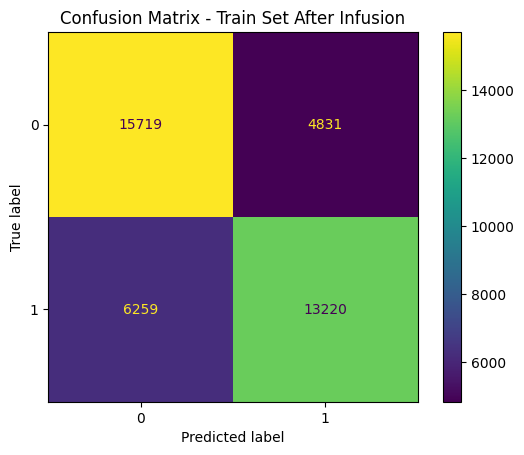

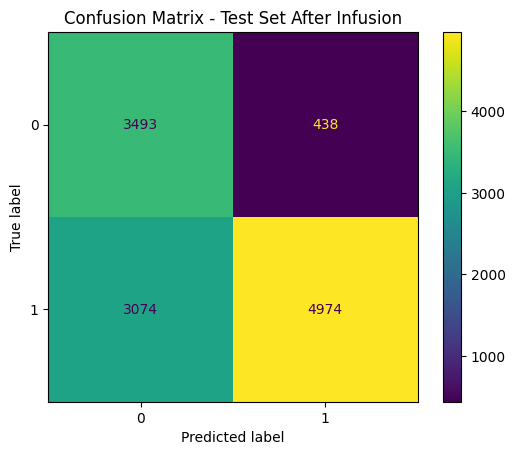

In [7]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_train_pred_after, y_train_after))
disp.plot()
plt.title("Confusion Matrix - Train Set After Infusion")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix(y_test_pred_after, y_test_after))
disp.plot()
plt.title("Confusion Matrix - Test Set After Infusion")
plt.show()

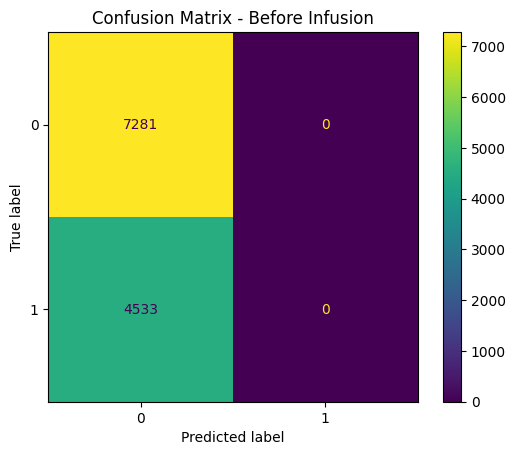

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred_before, y_before))
disp.plot()
plt.title("Confusion Matrix - Before Infusion")
plt.show()

c:\Users\Bruna\anaconda3\envs\TD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


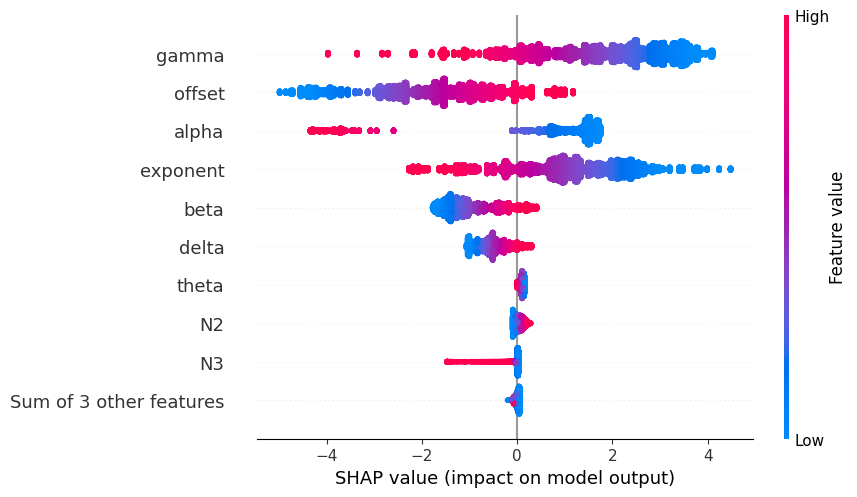

In [9]:
import shap

shap.initjs()

X_background = X_train_after.sample(n=min(200, len(X_train_after)), random_state=0)

# 4. SHAP
explainer = shap.LinearExplainer(model, X_background, feature_names=feature_names)
shap_values = explainer(X_test_after)
shap.plots.beeswarm(shap_values)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.


True label: placebo
Predicted prob DMT: 0.626650348884393


findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


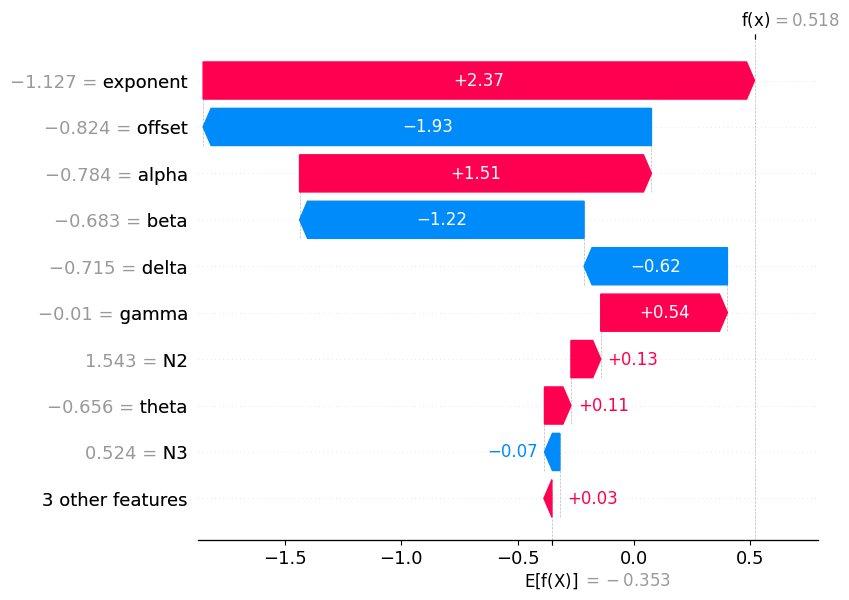

In [10]:
idx = 10  # index in X_test to inspect
print("True label:", "DMT" if y_test_after.iloc[idx] == 1 else "placebo")
print("Predicted prob DMT:", model.predict_proba(X_test_after.iloc[[idx]])[0, 1])

shap.plots.waterfall(shap_values[idx])